<a href="https://colab.research.google.com/github/ayberkcorp/cap5610-machine_learning/blob/master/hw2/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1

## Imports/Reading Data

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import graphviz
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, SGDClassifier

train_df = pd.read_csv('https://raw.githubusercontent.com/ayberkcorp/cap5610-machine_learning/master/Titanic/train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/ayberkcorp/cap5610-machine_learning/master/Titanic/test.csv')
combine = [train_df, test_df]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1) Preprocess your Titanic training data.

In [2]:
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Name', 'Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

guess_ages = np.zeros((2,3))
guess_ages

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            age_mean = guess_df.mean()
            age_std = guess_df.std()
            age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

freq_port = train_df.Embarked.dropna().mode()[0]
train_df = train_df.fillna(freq_port)

test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

combine = [train_df, test_df]

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [3]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22,1,0,0,0
1,1,1,1,38,1,0,3,1
2,1,3,1,26,0,0,1,0
3,1,1,1,35,1,0,3,0
4,0,3,0,35,0,0,1,0


In [4]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34,0,0,0,2
1,893,3,1,47,1,0,0,0
2,894,2,0,62,0,0,1,2
3,895,3,0,27,0,0,1,0
4,896,3,1,22,1,1,1,0


### 2) Select a set of important features. Please show your selected features and explain how you perform feature selection.

We have already dropped PassengerId and Name since these are just identifiers. Ticket and Cabin were also dropped earlier with respect to Q14 and Q15 on hw1. Here is the correlation matrix of the remaining 8 features.

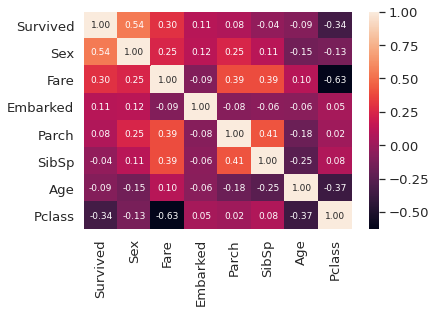

In [5]:
n = 8
corrMatrix = train_df.corr()
columns = corrMatrix.nlargest(n, 'Survived')['Survived'].index
c = np.corrcoef(train_df[columns].values.T)
sns.set(font_scale=1.2)
h = sns.heatmap(c, cbar=True, annot=True, annot_kws={'size':9}, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)
plt.show()

Survived will now be dropped because it is what we are trying to predict.

In [6]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 7))

Now we will use SelectKBest for feature selection.

In [7]:
SKB = SelectKBest(score_func=chi2, k=4)
fit = SKB.fit(X_train, Y_train)
print(fit.scores_)
X_train.head()

[ 30.87369944 170.34812709  41.39182855   2.58186538  10.09749911
  64.72249278  11.35311684]


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22,1,0,0,0
1,1,1,38,1,0,3,1
2,3,1,26,0,0,1,0
3,1,1,35,1,0,3,0
4,3,0,35,0,0,1,0


As we can see, Pclass, Sex, Age, and Fare have the highest score. So we now drop the other 3 features.

In [8]:
X_train = X_train.drop(["SibSp", "Parch", "Embarked"], axis=1)
X_test = X_test.drop(["SibSp", "Parch", "Embarked"], axis=1)
X_train.shape, X_test.shape

((891, 4), (418, 4))

### 3) Learn a decision tree model with the Titanic training data using Gini index, plot your decision tree.

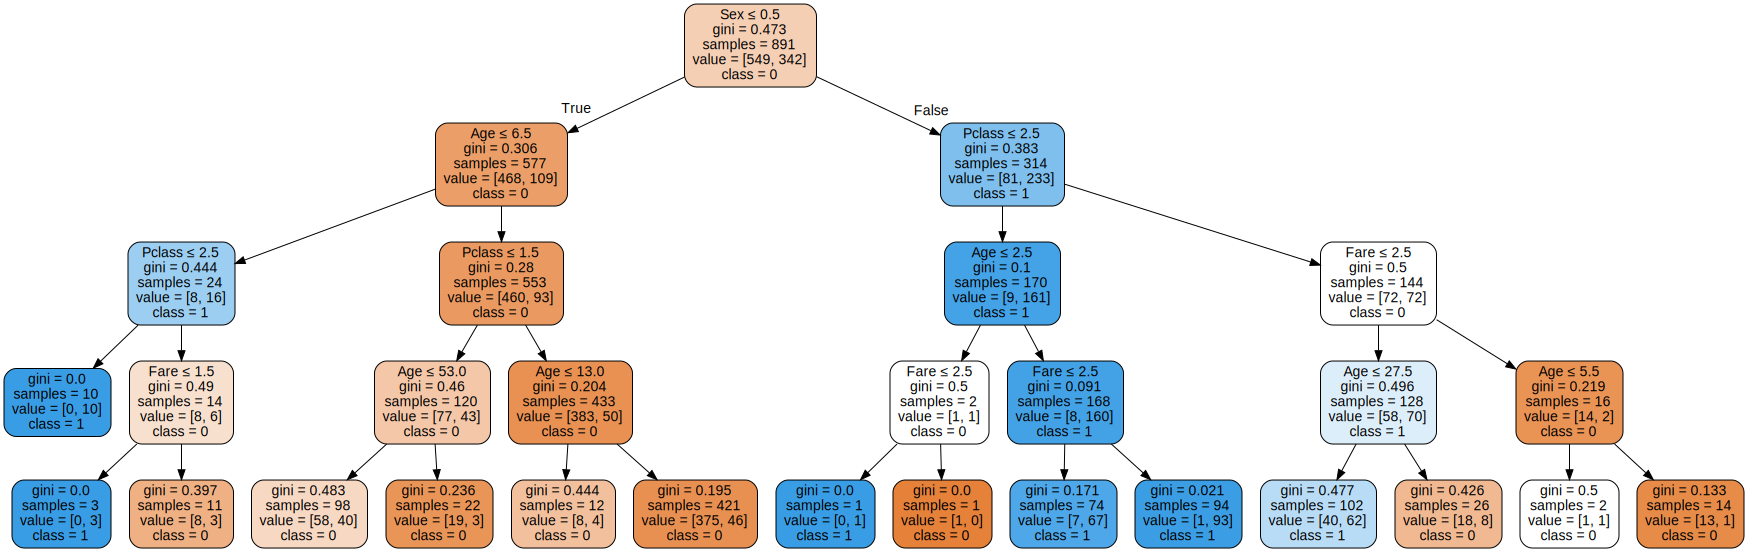

In [9]:
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=4)
decision_tree.fit(X_train, Y_train)

data = export_graphviz(decision_tree, out_file=None,
                       feature_names=X_train.columns.values,
                       class_names=['0', '1'], filled=True,
                       rounded=True, special_characters=True)

graph = graphviz.Source(data, format="png")
graph

### 4) Apply the five-fold cross validation of the decision tree learning algorithm to the Titanic training data to extract average classification accuracy.

In [10]:
decision_tree = DecisionTreeClassifier()
acc_scores = cross_val_score(decision_tree, X_train, y=Y_train, cv=5)
acc_scores.mean()

0.792436130814136

### 5) Apply the five-fold cross validation of the random forest learning algorithm to the Titanic training data to extract average classification accuracy.

In [11]:
random_forest = RandomForestClassifier()
acc_scores = cross_val_score(random_forest, X_train, y=Y_train, cv=5)
acc_scores.mean()

0.8014123407193523

### 6) Which algorithm is better, Decision Tree or Random Forest?

We see that the random forest learning algorithm had a higher average classification accuracy than the decision tree learning algorithm (0.801>0.792). However, comparing average classification accuracies of various algorithms is not always a robust determiner of learning performance. We would also need to analyze F1 scores and AUC scores for both models to be sure.

From our readings, we know that the random forest algorithm is better than the decision tree algorithm, especially when it comes to overfitting. Our results in this run confirm this conclusion.

### 7) What can you learn from the algorithm comparison and analysis?

Generally, random forests are known to perform better than decision trees. They operate by creating multiple decision trees, thus decreasing variance and the risk of overfitting the training data. For time complexity, decision trees are better than random forests when training time needs to be reduced as the latter takes more time due to the need of training each tree inside of it.